# Rearc Quest Part 3 - Data Analytics

#### Notebook Structure and Outline:

- **User Input Section**

- **Notebook Technical Setup**

- **Data Loading from S3**

- **Data Review and Cleanup**
    - **BLS Data Setup**
    - **DataUSA Data Setup**

- **Analysis and Requirements Fulfillment**


## User Input Section

In [1]:
# hard coded values
# not for production use

bucket_name = 'bucket-rearc-quest-mmorris'
bls_bucket_directory = 'bls_data' 
bls_filename = 'pr.data.0.Current'

datausa_bucket_directory = 'datausa_data' 
datausa_filename = 'datausa_acs_yg_total_population_1.json' 

In [2]:
# Requirement 1: Population Data Analysis Filters
Nation = 'United States'
Year_start = 2013
Year_end = 2018

In [3]:
# Requirement 3: Quarterly Labor and Population Statistics
series_id = 'PRS30006032' 
period = 'Q01'

In [28]:
# Output file names

# Requirement 0
bls_data_filename = f'../reports/part_3_req_0_bls_data.csv'
datausa_data_filename = f'../reports/part_3_req_0_datausa_data.csv'

# Requirement 1
population_statistics_filename = f'../reports/part_3_req_1_population_statistics.csv'

# Requirement 2
best_years_filename = f'../reports/part_3_req_2_best_years.csv'

# Requirement 3
first_qtr_combined_filename = f'../reports/part_3_req_3_first_qtr_combined.csv'
chart_filename_jpg = f'../reports/part_3_req_3_labor_population_chart_{series_id}_{period}.jpg'


## Notebook Technical Setup Section

In [5]:
%pip install -q pandas matplotlib seaborn plotly s3fs boto3 python-dotenv

Note: you may need to restart the kernel to use updated packages.


In [6]:
# Load environment variables from .env file
from dotenv import load_dotenv
import os

# Load .env file from the project root directory
load_dotenv()

# Get AWS credentials from environment variables
aws_access_key = os.getenv('AWS_ACCESS_KEY_ID')
aws_secret_key = os.getenv('AWS_SECRET_ACCESS_KEY')
aws_region = os.getenv('AWS_DEFAULT_REGION', 'us-east-1')

In [7]:
# Import pandas and other data analysis libraries
import pandas as pd
import boto3
from io import StringIO, BytesIO
import json

print(f"Pandas version: {pd.__version__}")

Pandas version: 2.3.3


## Data Loading from S3

We can directly access the S3 bucket files, since we have hard coded their references. Likely in production, a discovery process for new/changed files would be called for.

#### Approach
- define a reader function for each file type
- iteratively update the reader function to get a workable initial dataframe 
    - Noted that the BLS file is actually TSV not CSV, and has headers. Read the file with the `\t` separator
    - Noted that the BLS file, read as TSV, has errant spaces in column names so add `skipinitialspace=True` to the `read_csv()` and do a `strip()` on the column names

In [8]:
# Initialize S3 client
s3_client = boto3.client('s3')

# Function to read CSV (technically TSV) files from S3
# Handle tab separator, header and strip leading/trailing spaces
def read_csv_from_s3(bucket, key):
    response = s3_client.get_object(Bucket=bucket, Key=key)
    df = pd.read_csv(response['Body'], sep='\t', header=0, skipinitialspace=True)
    df.columns = df.columns.str.strip()  # Strip spaces from column names
    return df

# Function to read JSON files from S3
def read_json_from_s3(bucket, key):
    response = s3_client.get_object(Bucket=bucket, Key=key)
    content = response['Body'].read().decode('utf-8')
    # Handle JSON lines format
    if content.strip().startswith('{'):
        lines = content.strip().split('\n')
        data = [json.loads(line) for line in lines if line.strip()]
        return pd.DataFrame(data)
    else:
        return pd.read_json(StringIO(content))

In [9]:
# read the files from S3
try:
    bls_df = read_csv_from_s3(bucket_name, f"{bls_bucket_directory}/{bls_filename}")
    print(f"BLS data loaded: {bls_df.shape[0]} rows, {bls_df.shape[1]} columns")
    print("BLS columns:", list(bls_df.columns))

    datausa_df = read_json_from_s3(bucket_name, f"{datausa_bucket_directory}/{datausa_filename}")
    print(f"DataUSA data loaded: {datausa_df.shape[0]} rows, {datausa_df.shape[1]} columns")
    print("DataUSA columns:", list(datausa_df.columns))

except Exception as e:
    print(f"Error reading from S3: {e}")

BLS data loaded: 37239 rows, 5 columns
BLS columns: ['series_id', 'year', 'period', 'value', 'footnote_codes']
DataUSA data loaded: 1 rows, 4 columns
DataUSA columns: ['annotations', 'page', 'columns', 'data']


## Review and cleanup the datasets
This section is a combinataion of exploration of the datasets and cleaning them up into a working set of dataframes that are suitable for analysis.

#### Approach
- Review the dataframes content and structure with visual inspection
- Apply shaping and cleanup methods 
- Define a clean working dataframe: 
    - `bls_working_df`
    - `datausa_working_df`

### BLS Data Setup
- Spaces from column headers are also in text columns [`series_id`,`period`], so `strip()` those as well
- `footnote_codes` column appears fully unused, so remove it

In [10]:
bls_df.head()

,series_id,year,period,value,footnote_codes
0,PRS30006011,1995,Q01,2.6,NaN
1,PRS30006011,1995,Q02,2.1,NaN
2,PRS30006011,1995,Q03,0.9,NaN
3,PRS30006011,1995,Q04,0.1,NaN
4,PRS30006011,1995,Q05,1.4,NaN


In [11]:
bls_df.dtypes

series_id          object
year                int64
period             object
value             float64
footnote_codes     object
dtype: object

In [12]:
# normally would want to handle string column cleanup programatically not individually
bls_df['series_id'] = bls_df['series_id'].str.strip()
bls_df['period'] = bls_df['period'].str.strip()
bls_working_df = bls_df[['series_id', 'year', 'period', 'value']]
bls_working_df.head()

,series_id,year,period,value
0,PRS30006011,1995,Q01,2.6
1,PRS30006011,1995,Q02,2.1
2,PRS30006011,1995,Q03,0.9
3,PRS30006011,1995,Q04,0.1
4,PRS30006011,1995,Q05,1.4


### DataUSA Data Setup
I expect to have to manipulate the DataUSA json source to get all the desired data out of one key, based on the sample of it I saw while downloading it.

- Only the `data` key has data we need, the others will get removed
- The `data` column is a `list` of `dicts`, so it first needs to be exploded to one row per dict
- Then apply `normalize()` to extract keys as columns and values as rows
- Finally apply `strip()` to the text columns for safety

In [13]:
datausa_df.head()

,annotations,page,columns,data
0,{'dataset_link': 'http://www.census.gov/progra...,"{'limit': 0, 'offset': 0, 'total': 10}","[Nation ID, Nation, Year, Population]","[{'Nation ID': '01000US', 'Nation': 'United St..."


In [14]:
datausa_exploded_df = datausa_df.explode('data')
datausa_exploded_df.head()

,annotations,page,columns,data
0,{'dataset_link': 'http://www.census.gov/progra...,"{'limit': 0, 'offset': 0, 'total': 10}","[Nation ID, Nation, Year, Population]","{'Nation ID': '01000US', 'Nation': 'United Sta..."
0,{'dataset_link': 'http://www.census.gov/progra...,"{'limit': 0, 'offset': 0, 'total': 10}","[Nation ID, Nation, Year, Population]","{'Nation ID': '01000US', 'Nation': 'United Sta..."
0,{'dataset_link': 'http://www.census.gov/progra...,"{'limit': 0, 'offset': 0, 'total': 10}","[Nation ID, Nation, Year, Population]","{'Nation ID': '01000US', 'Nation': 'United Sta..."
0,{'dataset_link': 'http://www.census.gov/progra...,"{'limit': 0, 'offset': 0, 'total': 10}","[Nation ID, Nation, Year, Population]","{'Nation ID': '01000US', 'Nation': 'United Sta..."
0,{'dataset_link': 'http://www.census.gov/progra...,"{'limit': 0, 'offset': 0, 'total': 10}","[Nation ID, Nation, Year, Population]","{'Nation ID': '01000US', 'Nation': 'United Sta..."


In [15]:
datausa_working_df = pd.json_normalize(datausa_exploded_df['data'])
datausa_working_df.head()

,Nation ID,Nation,Year,Population
0,01000US,United States,2013,316128839.0
1,01000US,United States,2014,318857056.0
2,01000US,United States,2015,321418821.0
3,01000US,United States,2016,323127515.0
4,01000US,United States,2017,325719178.0


In [16]:
datausa_working_df.dtypes

Nation ID      object
Nation         object
Year            int64
Population    float64
dtype: object

In [17]:
# normally would want to handle string column cleanup programatically not individually
datausa_working_df['Nation ID'] = datausa_working_df['Nation ID'].str.strip()
datausa_working_df['Nation'] = datausa_working_df['Nation'].str.strip()
datausa_working_df.head()

,Nation ID,Nation,Year,Population
0,01000US,United States,2013,316128839.0
1,01000US,United States,2014,318857056.0
2,01000US,United States,2015,321418821.0
3,01000US,United States,2016,323127515.0
4,01000US,United States,2017,325719178.0


## Part 3 Requirement 0 
- The loaded and cleaned data is output to the `../reports` folder

In [18]:
# pr.data.0.Current Dataframe
bls_working_df

bls_working_df.to_csv(bls_data_filename, index=False)
print(f"CSV file created: {bls_data_filename}")
print(f"Size: {os.path.getsize(bls_data_filename)} bytes")

CSV file created: ../reports/part_3_req_0_bls_data.csv
Size: 1016031 bytes


In [19]:
# Population JSON Dataframe
datausa_working_df

datausa_working_df.to_csv(datausa_data_filename, index=False)
print(f"CSV file created: {datausa_data_filename}")
print(f"Size: {os.path.getsize(datausa_data_filename)} bytes")

CSV file created: ../reports/part_3_req_0_datausa_data.csv
Size: 434 bytes


## Population Analysis
'Using the dataframe from the population data API (Part 2), generate the mean and the standard deviation of the annual US population across the years [2013, 2018] inclusive.'

#### Approach
- The request above will result in a dataframe with only two values (plus the lineage columns for the Nation) - [`Nation`,`mean`,`stddev`]
- The `year` filter must be applied prior to aggregation
- The `Nation` filter can be applied after aggregation
- For simplicity the filters will be hardcoded; presumably a real use case would want all `Nation`s and the ability to dynamically filter, perhaps a comparison chart with a time series change, etc

In [20]:
population_analysis_df = datausa_working_df[
                    (datausa_working_df['Year'] >= Year_start) 
                   & (datausa_working_df['Year'] <= Year_end)] \
    .groupby('Nation') \
    .agg({'Population': ['mean', 'std']}) \
    .reset_index()
population_analysis_df

Nation   Population              
                         mean           std
0  United States  322069808.0  4.158441e+06

## Part 3 Requirement 1
- Output the data to the `../reports/` folder

In [21]:
# Filter to the requested input Nation's statistics
population_analysis_df[population_analysis_df['Nation'] == Nation]

population_analysis_df.to_csv(population_statistics_filename, index=False)
print(f"CSV file created: {population_statistics_filename}")
print(f"Size: {os.path.getsize(population_statistics_filename)} bytes")

CSV file created: ../reports/part_3_req_1_population_statistics.csv
Size: 86 bytes


## Best Labor Year Analysis
'Using the dataframe from the time-series (Part 1), For every series_id, find the best year: the year with the max/largest sum of "value" for all quarters in that year. Generate a report with each series id, the best year for that series, and the summed value for that year.'

#### Approach
- The request will need an output of the Annual Value, with the Year and Series_ID - [`series_id`,`year`,`sum(value)`]
- Getting the necessary data will require summing the `value` column grouped by `series_id` and `year` 
- Comparing years within a series will need a window function, taking the first row per `series_id`, when ordered by `sum(value)` descending
- Doing a little data profiling, it looks like each series continues for the same duration of years but presumably has different meanings (I had earlier viewed series as ending at a given year and new series taking over the following year.) This means a valid answer could be the same year, with different values, for different series.

In [22]:
# View the initial aggregated data
bls_grouped_df = bls_working_df.groupby(['series_id', 'year']) \
    .agg({'value': 'sum'}) \
    .reset_index() \
    .rename(columns={'value':'annual_value'})
bls_grouped_df

,series_id,year,annual_value
0,PRS30006011,1995,7.100
1,PRS30006011,1996,-0.500
2,PRS30006011,1997,4.400
3,PRS30006011,1998,4.200
4,PRS30006011,1999,-7.700
...,...,...,...
8557,PRS88003203,2021,523.634
8558,PRS88003203,2022,562.520
8559,PRS88003203,2023,577.546
8560,PRS88003203,2024,583.441


In [23]:
# Rank the grouped data by annual_value descending within each series_id
# then filter to only the highest ranked year, i.e. the max value in each series
bls_ranked_df = bls_grouped_df
bls_ranked_df['rank'] = bls_ranked_df \
    .groupby('series_id')['annual_value'] \
    .rank(ascending=False)
bls_best_df = bls_ranked_df \
    .sort_values(['series_id', 'rank']) \
    .query('rank == 1')[['series_id', 'year', 'annual_value']] \
    .rename(columns={'year':'best_year'})
bls_best_df

,series_id,best_year,annual_value
27,PRS30006011,2022,20.500
58,PRS30006012,2022,17.100
65,PRS30006013,1998,705.895
108,PRS30006021,2010,17.700
139,PRS30006022,2010,12.400
...,...,...,...
8414,PRS88003192,2002,282.800
8467,PRS88003193,2024,860.838
8496,PRS88003201,2022,37.200
8527,PRS88003202,2022,28.700


## Part 3 Requirement 2
Presumably the annual_values represent different measures per series, so they are likely not additive over series. In other words, summing annual_value over series to get a year-value is probably nonsceniscal.

Instead, generate a CSV of all the values for other use. The file is included in the `../reports/` folder.

In [24]:
with pd.option_context('display.max_rows', None):
        print(bls_best_df)

bls_best_df.to_csv(best_years_filename, index=False)
print(f"CSV file created: {best_years_filename}")
print(f"Size: {os.path.getsize(best_years_filename)} bytes")


        series_id  best_year  annual_value
27    PRS30006011       2022        20.500
58    PRS30006012       2022        17.100
65    PRS30006013       1998       705.895
108   PRS30006021       2010        17.700
139   PRS30006022       2010        12.400
174   PRS30006023       2014       503.216
213   PRS30006031       2022        20.500
243   PRS30006032       2021        17.100
251   PRS30006033       1998       702.672
306   PRS30006061       2022        37.000
336   PRS30006062       2021        31.600
370   PRS30006063       2024       646.748
398   PRS30006081       2021        24.400
425   PRS30006082       2021        24.400
452   PRS30006083       2021       110.742
460   PRS30006091       2002        43.300
491   PRS30006092       2002        44.400
533   PRS30006093       2013       514.156
571   PRS30006101       2020        33.500
602   PRS30006102       2020        36.200
637   PRS30006103       2024       644.924
664   PRS30006111       2020        34.200
683   PRS30

## First Quarter Combined Analysis
'Using both dataframes from Part 1 and Part 2, generate a report that will provide the value for series_id = PRS30006032 and period = Q01 and the population for that given year (if available in the population dataset).'

#### Approach
- The output should have columns for the Population, along with all the series data - [`series_id`,`year`,`period`,`value`,`Population`]
- The two datasets share the `Year` column, and the grain of the population dataset is at a year level. 
- Join the datasets, then apply the filters from hard-coded values. Again a typical request might instead by to allow dynamic filtering of the data by chosing a series_id, quarter (period), etc.

In [25]:
first_qtr_combined_df = pd.merge(bls_working_df, \
                                 datausa_working_df[['Year', 'Population']], \
                                left_on='year', right_on='Year', how='left') \
                        .query(f"series_id == '{series_id}' and period == '{period}'") \
                        [['series_id', 'year', 'period', 'value', 'Population']]
first_qtr_combined_df.head()

,series_id,year,period,value,Population
1064,PRS30006032,1995,Q01,0.0,NaN
1069,PRS30006032,1996,Q01,-4.2,NaN
1074,PRS30006032,1997,Q01,2.8,NaN
1079,PRS30006032,1998,Q01,0.9,NaN
1084,PRS30006032,1999,Q01,-4.1,NaN


## Part 3 Requirement 3
- generate a CSV of the given series and quarter's values and available population count. The file is included in the `../reports/` folder.
- Just for fun I had Claude generate a bar and line chart to compare the value of the given series for each year, along with the population. It does not seem like these two values have any correlation, especially since so much data is missing (and population always increases, and patterns are felt in differences over decades...).

In [26]:
with pd.option_context('display.max_rows', None):
        print(first_qtr_combined_df)

first_qtr_combined_df.to_csv(first_qtr_combined_filename, index=False)
print(f"CSV file created: {first_qtr_combined_filename}")
print(f"Size: {os.path.getsize(first_qtr_combined_filename)} bytes")

        series_id  year period  value   Population
1064  PRS30006032  1995    Q01    0.0          NaN
1069  PRS30006032  1996    Q01   -4.2          NaN
1074  PRS30006032  1997    Q01    2.8          NaN
1079  PRS30006032  1998    Q01    0.9          NaN
1084  PRS30006032  1999    Q01   -4.1          NaN
1089  PRS30006032  2000    Q01    0.5          NaN
1094  PRS30006032  2001    Q01   -6.3          NaN
1099  PRS30006032  2002    Q01   -6.6          NaN
1104  PRS30006032  2003    Q01   -5.7          NaN
1109  PRS30006032  2004    Q01    2.0          NaN
1114  PRS30006032  2005    Q01   -0.5          NaN
1119  PRS30006032  2006    Q01    1.8          NaN
1124  PRS30006032  2007    Q01   -0.8          NaN
1129  PRS30006032  2008    Q01   -3.5          NaN
1134  PRS30006032  2009    Q01  -21.0          NaN
1139  PRS30006032  2010    Q01    3.2          NaN
1144  PRS30006032  2011    Q01    1.5          NaN
1149  PRS30006032  2012    Q01    2.5          NaN
1154  PRS30006032  2013    Q01 

FIRST QUARTER COMBINED VISUALIZATION
📊 Chart saved as: ../reports/part_3_req_3_labor_population_chart_PRS30006032_Q01.jpg


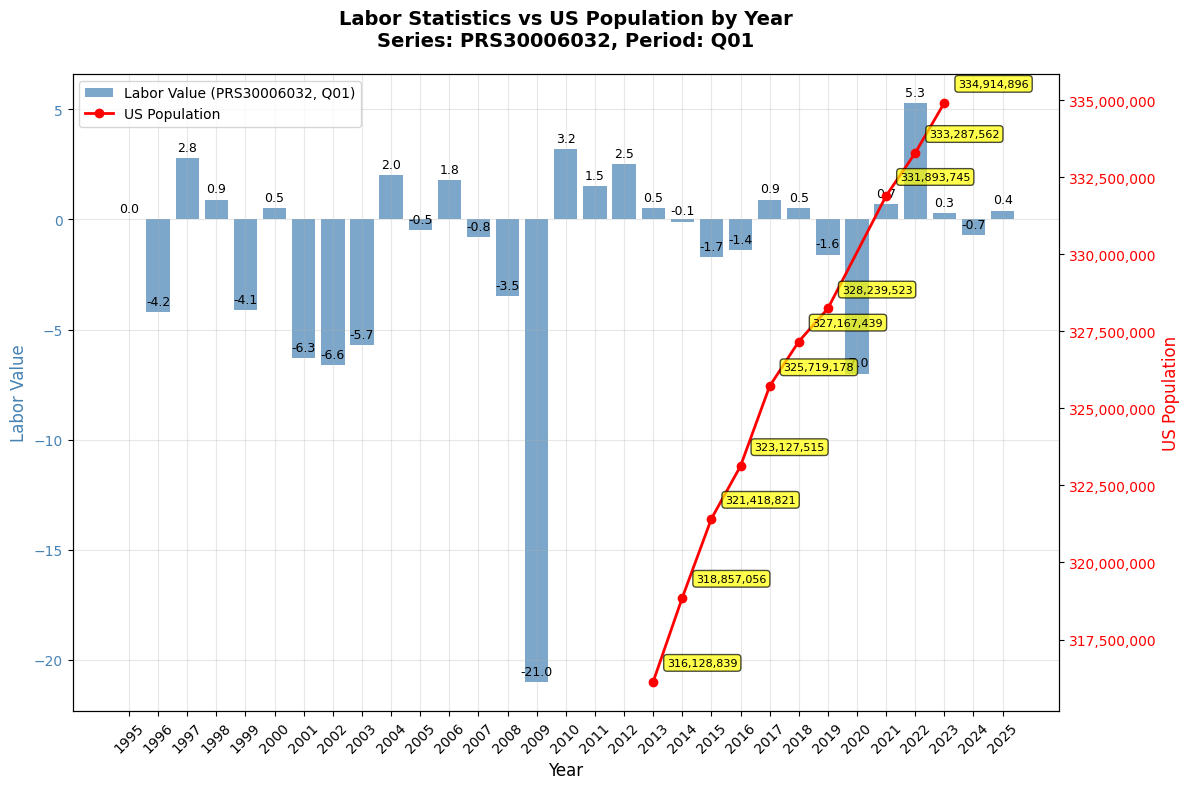

In [29]:
# Create combined bar and line chart for first quarter analysis
import matplotlib.pyplot as plt
import numpy as np

if 'first_qtr_combined_df' in locals() and len(first_qtr_combined_df) > 0:
    
    print("=" * 60)
    print("FIRST QUARTER COMBINED VISUALIZATION")
    print("=" * 60)
    
    # Prepare the data
    chart_data = first_qtr_combined_df.copy()
    chart_data = chart_data.sort_values('year')
    
    # Replace NaN population values with None for proper line breaks
    chart_data['Population_clean'] = chart_data['Population'].where(
        chart_data['Population'].notna(), None
    )
    
    # Create the combined chart
    fig, ax1 = plt.subplots(figsize=(12, 8))
    
    # Bar chart for labor values (left y-axis)
    bars = ax1.bar(chart_data['year'], chart_data['value'], 
                   alpha=0.7, color='steelblue', 
                   label=f'Labor Value ({series_id}, {period})')
    
    ax1.set_xlabel('Year', fontsize=12)
    ax1.set_ylabel('Labor Value', fontsize=12, color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')
    ax1.grid(True, alpha=0.3)
    
    # Add value labels on bars
    for bar, value in zip(bars, chart_data['value']):
        height = bar.get_height()
        ax1.annotate(f'{value:.1f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=9)
    
    # Create second y-axis for population (line chart)
    ax2 = ax1.twinx()
    
    # Filter data where population is available
    pop_data = chart_data[chart_data['Population'].notna()]
    
    if len(pop_data) > 0:
        # Line chart for population (right y-axis)
        line = ax2.plot(pop_data['year'], pop_data['Population'], 
                       color='red', marker='o', linewidth=2, markersize=6,
                       label='US Population')
        
        ax2.set_ylabel('US Population', fontsize=12, color='red')
        ax2.tick_params(axis='y', labelcolor='red')
        
        # Format population y-axis with comma separators
        ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))
        
        # Add population labels on points
        for year, pop in zip(pop_data['year'], pop_data['Population']):
            ax2.annotate(f'{pop:,.0f}',
                        xy=(year, pop),
                        xytext=(10, 10),
                        textcoords="offset points",
                        ha='left', va='bottom',
                        fontsize=8,
                        bbox=dict(boxstyle='round,pad=0.3', facecolor='yellow', alpha=0.7))
    
    # Set title and format
    plt.title(f'Labor Statistics vs US Population by Year\nSeries: {series_id}, Period: {period}', 
              fontsize=14, fontweight='bold', pad=20)
    
    # Format x-axis
    ax1.set_xticks(chart_data['year'])
    ax1.set_xticklabels(chart_data['year'], rotation=45)
    
    # Add legends
    lines1, labels1 = ax1.get_legend_handles_labels()
    if len(pop_data) > 0:
        lines2, labels2 = ax2.get_legend_handles_labels()
        ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    else:
        ax1.legend(loc='upper left')
        # Add note about missing population data
        ax1.text(0.02, 0.98, 'Note: Population data not available for these years', 
                transform=ax1.transAxes, fontsize=10, 
                verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))
    
    plt.tight_layout()
    
    plt.savefig(chart_filename_jpg, dpi=300, bbox_inches='tight', format='jpeg')
    
    print(f"📊 Chart saved as: {chart_filename_jpg}")
    
    plt.show()